In [2]:
%pip install Faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Initialize Faker to generate random data
fake = Faker()

# Constants
NUM_PAYABLES = 1000
NUM_RECEIVABLES = 1000

# Define categories and possible values
payables_categories = ["Supplier Payments", "Logistics Costs", "Utilities and Rent", "Employee Salaries"]
receivables_categories = ["Customer Payments", "Vendor Rebates", "Leased Space Income", "Financing Products"]

suppliers = ["Procter & Gamble", "Unilever", "PepsiCo", "Nestle", "Kellogg's"]
vendors = ["FedEx", "SHIPHYPE", "Unicargo", "ShipBob","RLS Logistics","Zipline Logistics"]
tenants = ["Starbucks", "McDonald's", "Subway", "Burger King","Bakery",""]
payment_channels = ["Online", "In-Store"]
products = ["Walmart Credit Card", "Walmart Financing Plan"]
payment_rails = ["ACH","WIRES","INSTANT","RTPAY"]

# Function to generate payables data
def generate_payables(num):
    data = []
    for i in range(num):
        transaction_id = f"T{i+1:04}"  # Generate transaction ID as T0001, T0002, ...
        date = fake.date_between(start_date="-1y", end_date="today")
        amount = round(random.uniform(1000, 500000), 2)
        category = random.choice(payables_categories)
        payment_rail = random.choice(payment_rails)
        if category == "Supplier Payments":
            supplier_name = random.choice(suppliers)
        else:
            supplier_name = ""
        if category == "Logistics Costs":
            vendor_name = random.choice(vendors)
        else:
            vendor_name = ""
        if category == "Utilities and Rent":
            location = f"Store #{random.randint(1000, 9999)}"
        else:
            location = ""
        if category == "Employee Salaries":
            department = "Store Operations"
        else:
            department = ""
        data.append([transaction_id, date, amount, category,payment_rail, supplier_name, vendor_name, location, department, "Payable"])
    return data

# Function to generate receivables data
def generate_receivables(num):
    data = []
    for i in range(num):
        transaction_id = f"T{i+1+NUM_PAYABLES:04}"  # Start from T1001 for receivables
        date = fake.date_between(start_date="-1y", end_date="today")
        amount = round(random.uniform(1000, 1500000), 2)
        category = random.choice(receivables_categories)
        payment_rail = random.choice(payment_rails)
        if category == "Vendor Rebates":
            vendor_name = random.choice(suppliers)
        else:
            vendor_name = ""
        if category == "Leased Space Income":
            tenant_name = random.choice(tenants)
        else:
            tenant_name = ""
        if category == "Customer Payments":
            payment_channel = random.choice(payment_channels)
        else:
            payment_channel = ""
        if category == "Financing Products":
            product_name = random.choice(products)
        else:
            product_name = ""
        data.append([transaction_id, date, amount, category, payment_rail, vendor_name, tenant_name, payment_channel, product_name, "Receivable"])
    return data

# Generate data
payables_data = generate_payables(NUM_PAYABLES)
receivables_data = generate_receivables(NUM_RECEIVABLES)

# Create DataFrames
payables_df = pd.DataFrame(payables_data, columns=["Transaction ID", "Date", "Amount", "Category", "Payment Rail", "Supplier Name", "Vendor Name", "Location", "Department", "Type"])
receivables_df = pd.DataFrame(receivables_data, columns=["Transaction ID", "Date", "Amount", "Category", "Payment Rail", "Vendor Name", "Tenant Name", "Payment Channel", "Product Name", "Type"])

# Concatenate dataframes
combined_df = pd.concat([payables_df, receivables_df], ignore_index=True)

# Replace all NaN values with "" in a dataframe
combined_df = combined_df.fillna("")
# Save to CSV file
combined_df.to_csv("combined_transactions.csv", index=False)

# Download the CSV string as a file
# from google.colab import files
# files.download('combined_transactions.csv')

**ARIMA (AutoRegressive Integrated Moving Average)**

For time series forecasting, including forecasting financial data such as the combined transactions dataset you have. ARIMA is a widely used model for handling time series data and can be particularly effective when the data exhibits trends and seasonality.

Using ARIMA for Forecasting
1. Preparing the Data
First, ensure your data is in a suitable format for time series analysis:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming combined_df is already loaded with the combined data and Date column is datetime type

# Convert Date column to datetime format if not already
combined_df['Date'].dtypes
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
# Set Date column as index
combined_df.set_index('Date', inplace=True)

# Ensure the Amount column is numeric
combined_df['Amount'] = pd.to_numeric(combined_df['Amount'])

combined_df.head()

,Transaction ID,Amount,Category,Payment Rail,Supplier Name,Vendor Name,Location,Department,Type,Tenant Name,Payment Channel,Product Name
Date,,,,,,,,,,,,
2024-04-21,T0001,330786.35,Utilities and Rent,ACH,,,Store #8444,,Payable,,,
2023-08-29,T0002,16150.09,Utilities and Rent,RTPAY,,,Store #3334,,Payable,,,
2023-08-22,T0003,347830.11,Utilities and Rent,WIRES,,,Store #8713,,Payable,,,
2024-02-09,T0004,149973.02,Supplier Payments,RTPAY,Kellogg's,,,,Payable,,,
2024-04-13,T0005,35029.88,Utilities and Rent,RTPAY,,,Store #4457,,Payable,,,


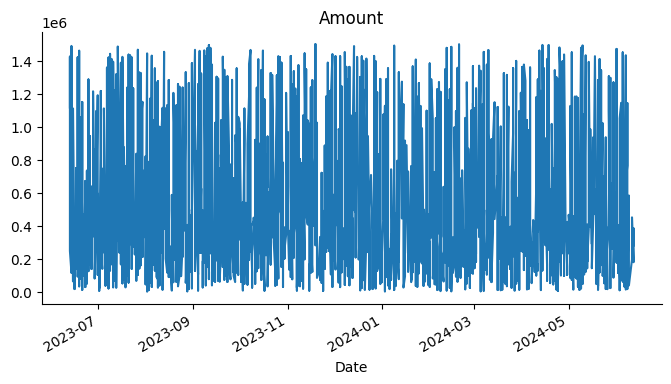

In [9]:
# @title Amount

from matplotlib import pyplot as plt
combined_df['Amount'].plot(kind='line', figsize=(8, 4), title='Amount')
plt.gca().spines[['top', 'right']].set_visible(False)

2. Checking Stationarity:
ARIMA models require the time series to be stationary, meaning its statistical properties such as mean, variance, and autocorrelation are constant over time. You can check stationarity using statistical tests like the Augmented Dickey-Fuller (ADF) test and visually inspecting plots:

In [10]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Example: Check stationarity for Amount column
check_stationarity(combined_df['Amount'])


ADF Statistic: -1.7196019045687703
p-value: 0.42104233309587746
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


From the above values , the data seems non stationary

Transforming a non-stationary time series into a stationary one is a crucial step before applying models like ARIMA. Common techniques include differencing, logarithmic transformation, and seasonal differencing.

1. Differencing

Differencing involves computing the difference between consecutive observations. It is often used to remove trends from the data.

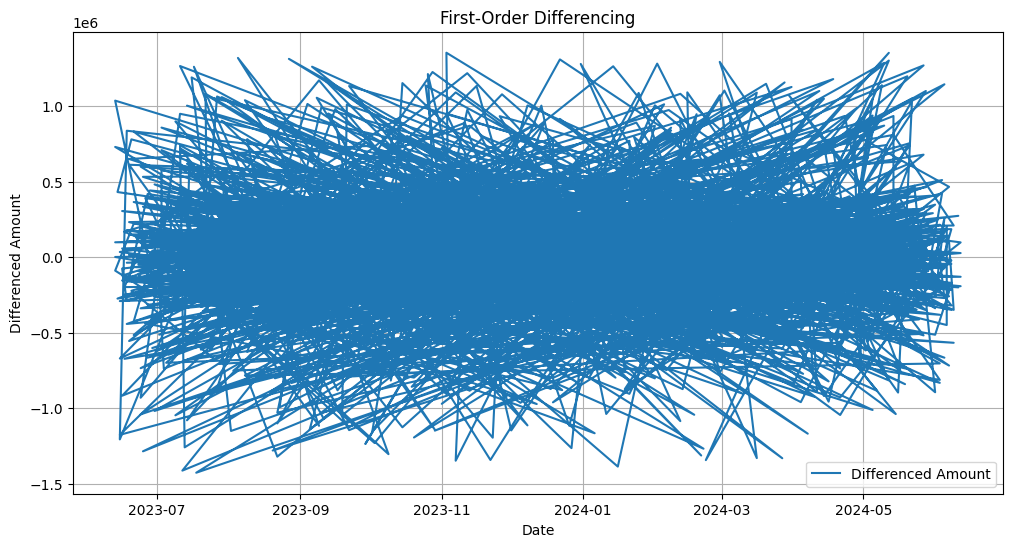

,Transaction ID,Amount,Category,Payment Rail,Supplier Name,Vendor Name,Location,Department,Type,Tenant Name,Payment Channel,Product Name,Amount_diff
Date,,,,,,,,,,,,,
2024-02-09,T0004,149973.02,Supplier Payments,RTPAY,Kellogg's,,,,Payable,,,,-197857.09
2024-04-13,T0005,35029.88,Utilities and Rent,RTPAY,,,Store #4457,,Payable,,,,-114943.14
2023-07-27,T0006,101756.07,Supplier Payments,INSTANT,Nestle,,,,Payable,,,,66726.19
2024-03-09,T0007,494702.92,Employee Salaries,RTPAY,,,,Store Operations,Payable,,,,392946.85
2023-08-18,T0008,482429.12,Utilities and Rent,RTPAY,,,Store #2114,,Payable,,,,-12273.80


In [13]:
# # First-order differencing

combined_df['Amount_diff'] = combined_df['Amount'].diff()
combined_df.dropna(inplace=True)  # Drop NaN values created by differencing

# Plot to visualize the differenced series
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Amount_diff'], label='Differenced Amount')
plt.xlabel('Date')
plt.ylabel('Differenced Amount')
plt.title('First-Order Differencing')
plt.legend()
plt.grid(True)
plt.show()

combined_df.head()


2. Logarithmic Transformation

Applying a logarithmic transformation can stabilize the variance in the data, especially if it grows exponentially over time.

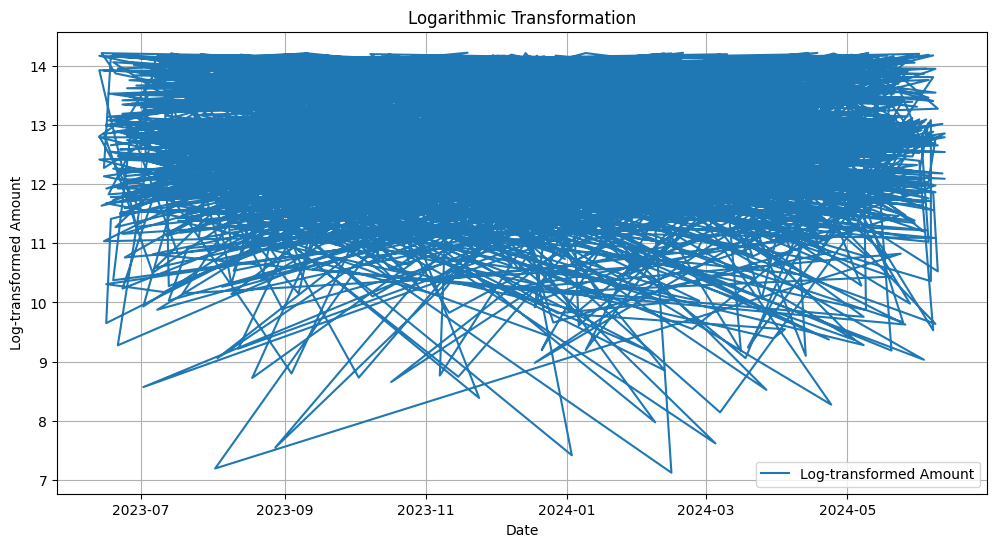

,Transaction ID,Amount,Category,Payment Rail,Supplier Name,Vendor Name,Location,Department,Type,Tenant Name,Payment Channel,Product Name,Amount_diff,Amount_log
Date,,,,,,,,,,,,,,
2024-02-09,T0004,149973.02,Supplier Payments,RTPAY,Kellogg's,,,,Payable,,,,-197857.09,11.918211
2024-04-13,T0005,35029.88,Utilities and Rent,RTPAY,,,Store #4457,,Payable,,,,-114943.14,10.463957
2023-07-27,T0006,101756.07,Supplier Payments,INSTANT,Nestle,,,,Payable,,,,66726.19,11.530334
2024-03-09,T0007,494702.92,Employee Salaries,RTPAY,,,,Store Operations,Payable,,,,392946.85,13.111713
2023-08-18,T0008,482429.12,Utilities and Rent,RTPAY,,,Store #2114,,Payable,,,,-12273.80,13.086589


In [15]:
# Logarithmic transformation
combined_df['Amount_log'] = np.log(combined_df['Amount'])

# Plot to visualize the transformed series
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Amount_log'], label='Log-transformed Amount')
plt.xlabel('Date')
plt.ylabel('Log-transformed Amount')
plt.title('Logarithmic Transformation')
plt.legend()
plt.grid(True)
plt.show()

combined_df.head()

3. Seasonal Differencing

If your data exhibits seasonal patterns (e.g., monthly or quarterly cycles), you can perform seasonal differencing by subtracting the observation from the same time in the previous cycle.

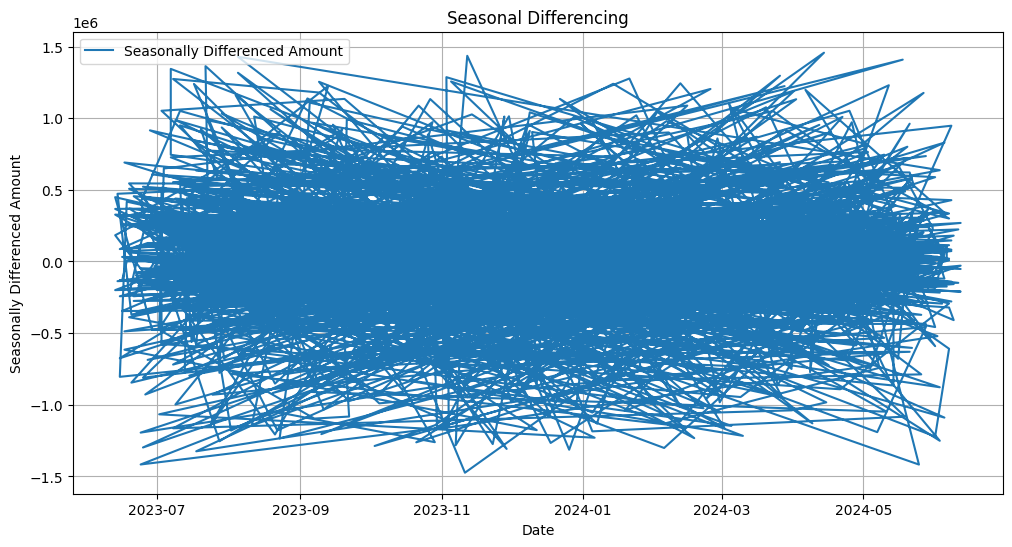

,Transaction ID,Amount,Category,Payment Rail,Supplier Name,Vendor Name,Location,Department,Type,Tenant Name,Payment Channel,Product Name,Amount_diff,Amount_log
Date,,,,,,,,,,,,,,
2024-02-09,T0004,149973.02,Supplier Payments,RTPAY,Kellogg's,,,,Payable,,,,-197857.09,11.918211
2024-04-13,T0005,35029.88,Utilities and Rent,RTPAY,,,Store #4457,,Payable,,,,-114943.14,10.463957
2023-07-27,T0006,101756.07,Supplier Payments,INSTANT,Nestle,,,,Payable,,,,66726.19,11.530334
2024-03-09,T0007,494702.92,Employee Salaries,RTPAY,,,,Store Operations,Payable,,,,392946.85,13.111713
2023-08-18,T0008,482429.12,Utilities and Rent,RTPAY,,,Store #2114,,Payable,,,,-12273.80,13.086589


In [16]:
# Seasonal differencing (e.g., for monthly data)
seasonal_diff = combined_df['Amount'].diff(12)  # Assuming monthly data, differencing with lag of 12

# Plot to visualize the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, seasonal_diff, label='Seasonally Differenced Amount')
plt.xlabel('Date')
plt.ylabel('Seasonally Differenced Amount')
plt.title('Seasonal Differencing')
plt.legend()
plt.grid(True)
plt.show()

combined_df.head()


3. Building and Training the ARIMA Model
Once stationary, you can build the ARIMA model and train it on your data:

In [18]:
# Define the order parameters
p = 2  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order

# Fit ARIMA model
model = ARIMA(combined_df['Amount'], order=(p, d, q))  # Specify appropriate values for p, d, q
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                 1997
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -28192.751
Date:                Thu, 13 Jun 2024   AIC                          56393.501
Time:                        18:13:13   BIC                          56415.897
Sample:                             0   HQIC                         56401.725
                               - 1997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0021      0.023     -0.094      0.925      -0.046       0.042
ar.L2         -0.0437      0.022     -1.998      0.046      -0.087      -0.001
ma.L1         -0.9636      0.006   -162.422      0.0

4. Forecasting
Use the fitted model to make forecasts into the future:

Forecasting: Generate forecasts for a specified number of periods ahead using the forecast method of the fitted model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecasted Amounts: 1997    831561.938688
1998    856484.232687
1999    855776.465792
2000    854688.619469
2001    854721.860970
2002    854769.339971
2003    854767.786384
2004    854765.714383
2005    854765.786680
2006    854765.877094
Name: predicted_mean, dtype: float64


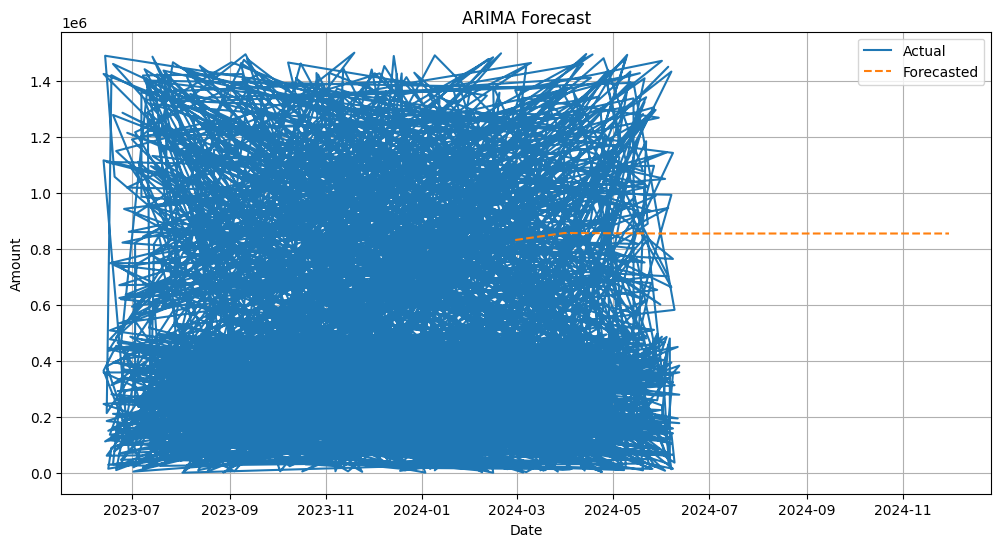

In [20]:
# Forecast
forecast_steps = 10  # Example: Forecasting 10 steps ahead
forecast = model_fit.forecast(steps=forecast_steps)

# Print forecasted values
print('Forecasted Amounts:', forecast)

# Plotting forecasted values
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Amount'], label='Actual')
plt.plot(pd.date_range(start=combined_df.index[-1], periods=forecast_steps, freq='M'), forecast, label='Forecasted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()


5. Evaluating the Model
Evaluate the model's performance using metrics like Mean Squared Error (MSE):

In [ ]:
# Example: Evaluate model performance
train_size = int(len(combined_df) * 0.8)  # 80-20 train-test split
train, test = combined_df.iloc[:train_size], combined_df.iloc[train_size:]
history = [x for x in train['Amount']]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))  # Re-fit the model for each test point
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Amount'].iloc[t]
    history.append(obs)

# Calculate MSE
mse = mean_squared_error(test['Amount'], predictions)
print('Mean Squared Error:', mse)
